# <center> Object Localization
 

### Theory
- [Multiple shots detection](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/object_localization_and_detection.html)
- [Single shot detection](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/single-shot-detectors.html)

### Datasets
- `URLs.COCO_TINY`: 200 images
- `URLs.COCO_SAMPLE`
- `URLs.PASCAL_2007`
- `URLs.PASCAL_2012`

### Foro
- https://forums.fast.ai/t/object-detection-in-fast-ai-v1/29266/80
- https://forums.fast.ai/t/object-detection/54585

### Notebooks
- https://www.kaggle.com/jachen36/coco-tiny-test-prediction
- https://github.com/ChristianMarzahl/ObjectDetection/blob/master/object_detection_fastai/examples/CocoTiny_Retina_Net.ipynb
- https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb
- [SSD](https://github.com/heye0507/dl_related/blob/master/play_ground/SSD_dev.ipynb)
- [Retina](https://github.com/heye0507/dl_related/blob/master/play_ground/Retina_net_dev.ipynb)

In [1]:
from fastai.vision import *

---
# <center> Get dataset
---

In [2]:
path = untar_data(URLs.COCO_TINY)
path.ls()

[PosixPath('/Users/javi/.fastai/data/coco_tiny/tmp.pth'),
 PosixPath('/Users/javi/.fastai/data/coco_tiny/train.json'),
 PosixPath('/Users/javi/.fastai/data/coco_tiny/train')]

In [3]:
images, lbl_bbox = get_annotations(path/'train.json')
len(images), images[0], lbl_bbox[0]

(200,
 '000000542959.jpg',
 [[[86.34, 32.52, 95.75, 41.050000000000004],
   [110.52, 98.12, 114.59, 100.07000000000001],
   [51.62, 91.28, 57.339999999999996, 95.23],
   [110.82, 110.48, 126.03999999999999, 125.03],
   [50.18, 96.63, 63.64, 115.3],
   [111.73, 0.69, 124.79, 12.49]],
  ['chair', 'vase', 'vase', 'chair', 'chair', 'chair']])

### Get Larget BBox
- Coco bounding box format: `[x, y, width, height]`

In [4]:
# Largest BBox by width * height
def get_lrg(b):
    if not b: raise Exception()
    lrg_idx = np.array([bbox[2]*bbox[3] for bbox in b[0]]).argmax()
    return [[b[0][lrg_idx]], [b[1][lrg_idx]]]

lbl_bbox_lrg = [get_lrg(b) for b in lbl_bbox]
lbl_bbox_lrg[:3]

[[[[110.82, 110.48, 126.03999999999999, 125.03]], ['chair']],
 [[[60.71, 118.42, 77.52, 128.0]], ['tv']],
 [[[48.61, 76.8, 122.25, 128.0]], ['vase']]]

In [5]:
img_bbox_pairs   = dict(zip(images, lbl_bbox_lrg))
img_bboxes_pairs = dict(zip(images, lbl_bbox))

get_bbox   = lambda o:img_bbox_pairs[o.name]
get_bboxes = lambda o:img_bboxes_pairs[o.name]

---
# <center> PART 1: Predict Only One BBox
---

### Create DataBatch

In [11]:
data = (ObjectItemList.from_folder(path) # Where are the images?        -> In path
        .split_by_rand_pct()             # How to split in train/valid? -> Randomly with the default 20% in valid
        .label_from_func(get_bbox)       # How to find the labels?      -> Use get_bbox
        #.add_test_folder('train')       # Where are the test images?   -> Use train images
        .transform(get_transforms(),     # Data augmentation?           -> Standard transforms
                   tfm_y=True,           #   Tranform also bbox labels? -> Yes
                   size=224)             #
                   #resize_method=ResizeMethod.SQUISH)
        .databunch(bs=16,                # Finally we convert to a DataBunch of batch size = 16
                   num_workers=0,        #  
                   collate_fn=bb_pad_collate)) # and we use bb_pad_collate

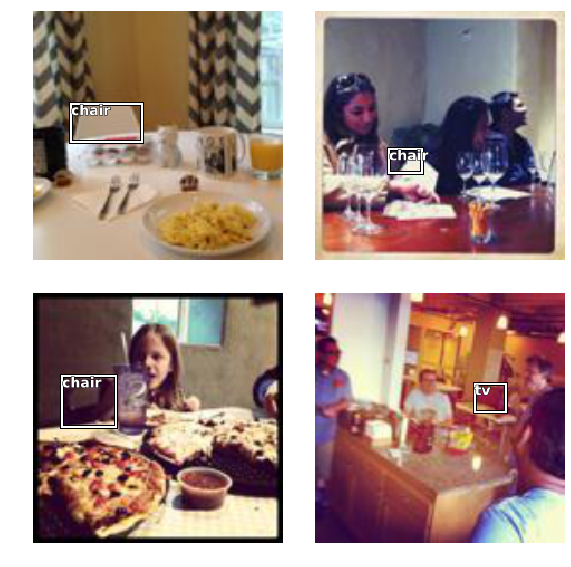

In [16]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(8,8))

### See augmentation

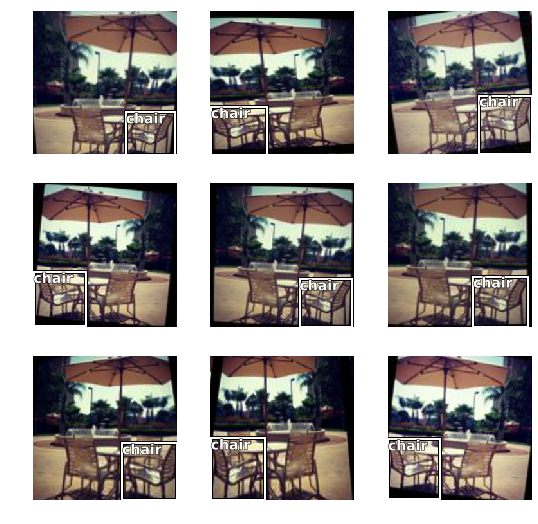

In [15]:
idx = 32
fig, axes = plt.subplots(3,3, figsize=(9,9))

# Image is augmented each time it is retrived
for i, ax in enumerate(axes.flat):
    img = data.train_ds[idx]
    img[0].show(y=img[1], ax=ax)

### See classes

In [14]:
data.classes

['background', 'book', 'chair', 'couch', 'remote', 'tv', 'vase']

# Train Neural Net

In [17]:
def loss_func(preds, targs, class_idx, **kwargs):
    return nn.L1Loss()(preds, targs.squeeze())

In [23]:
head_bbox = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4))
    # Maybe add nn.tanh since the values are [-1,1]
    
learn = cnn_learner(data        = data,
                    base_arch   = models.resnet18,
                    pretrained  = True,
                    custom_head = head_bbox,
                    model_dir   = '.')

learn.loss_func = loss_func

In [24]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

epoch,train_loss,valid_loss,time
0,1.692965,#na#,00:23
1,1.666285,#na#,00:23
2,1.646358,#na#,00:23
3,1.678012,#na#,00:23
4,1.686000,#na#,00:23
5,1.679597,#na#,00:24
6,1.612538,#na#,00:24
7,1.469124,#na#,00:24
8,2.124182,#na#,00:24


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


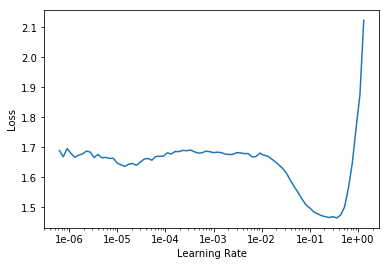

In [25]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(15, slice(0.03))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(15, max_lr = slice(0.001, 0.001/5), pct_start=0.5)

In [ ]:
learn.recorder.plot_losses()

# Check Validation Set

In [ ]:
preds, targs = learn.get_preds(ds_type=DatasetType.Valid)
targs = targs.squeeze()

In [ ]:
print(preds.shape, targs.shape)

In [ ]:
np.random.seed(24)
n = 10  # look at n samples, must be even
idxs = np.random.randint(0,len(data.valid_ds), size=n)
_, axes = plt.subplots(nrows=n//2, ncols=2, figsize = (n, n*2))
for i, ax in zip(idxs, axes.flat):
    img = data.valid_ds[i][0].data  # image resize after data is called else original image size
    img_name = Path(data.valid_ds.items[i]).name
    img_size = img.shape[1:]
    targ, pred = targs[i], preds[i]
    Image(img).show(ax=ax,
                    # target is white
                     y=ImageBBox.create(*img_size, 
                                        bboxes=targ.unsqueeze(0),
                                        scale=False),
                    title=img_name)
    # Prediction is red
    ImageBBox.create(*img_size, 
                     bboxes=pred.unsqueeze(0),
                     scale=False).show(ax=ax, color='red')

# Get prediction on test set.

In [27]:
len(learn.data.test_ds)

In [ ]:
learn.data.test_ds.tfm_y = False  # Will get "Exception: Not Implemented" since there is no y

In [ ]:
learn.data.test_ds[0]

In [ ]:
preds, targs = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
learn.data.one_batch(DatasetType.Test)

---
# <center> PART 2: Predict Multiple BBoxes
---

### Create DataBatch

In [24]:
data = (ObjectItemList.from_folder(path) # Where are the images?        -> In path
        .split_by_rand_pct()             # How to split in train/valid? -> Randomly with the default 20% in valid
        .label_from_func(get_bboxes)     # How to find the labels?      -> Use get_bbox
        #.add_test_folder('train')       # Where are the test images?   -> Use train images
        .transform(get_transforms(),     # Data augmentation?           -> Standard transforms
                   tfm_y=True,           #   Tranform also bbox labels? -> Yes
                   size=224)             #
                   #resize_method=ResizeMethod.SQUISH)
        .databunch(bs=16,                # Finally we convert to a DataBunch
                   num_workers=0,        #  
                   collate_fn=bb_pad_collate)) # and we use bb_pad_collate

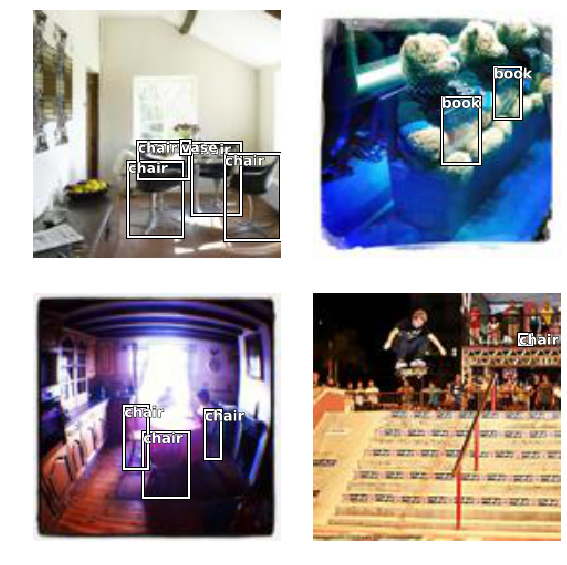

In [25]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(8,8))

### See augmentation

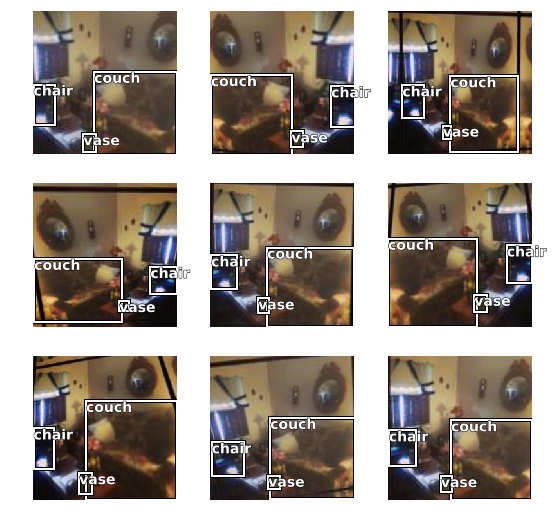

In [32]:
idx = 5
fig, axes = plt.subplots(3,3, figsize=(9,9))
for i, ax in enumerate(axes.flat):
    img = data.train_ds[idx]
    # image is augmented each time it is retrived
    img[0].show(y=img[1], ax=ax)

### See classes

In [29]:
data.classes

['background', 'book', 'chair', 'couch', 'remote', 'tv', 'vase']

In [28]:
data.train_ds.c

7

# Train RetinaNet

In [33]:
n_classes = data.train_ds.c

anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)],
                         ratios=[0.5, 1, 2],
                         scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)
#model.eval()

NameError: name 'create_anchors' is not defined

In [5]:
coco = DataBlock(
        blocks    = (ImageBlock, BBoxBlock, BBoxLblBlock),
        get_items = get_image_files,
        splitter  = RandomSplitter(),
        getters   = [noop, lambda o:lbl[o.name][0], lambda o:lbl[o.name][1]], n_inp=1)

dls = coco.databunch(
       coco_source,
       item_tfms=Resize(128),
       batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])

AttributeError: 'DataBlock' object has no attribute 'databunch'

In [7]:
coco.

TypeError: summary() missing 1 required positional argument: 'source'

In [2]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
idx=2
coco_fn,bbox = coco/'train'/images[idx],lbl_bbox[idx]
coco_img = timg(coco_fn)

NameError: name 'timg' is not defined